In [49]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2
from utils import *
from visuals import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Protest Analysis in MENAAP

This notebook analyzes protest events in the Middle East and North Africa (MENA) region using ACLED (Armed Conflict Location & Event Data Project) data. The analysis covers 157 countries globally and 21 countries in MENAAP. 

In [50]:
import pandas as pd 
#import geopandas as gpd 
import matplotlib.pyplot as plt
from wbpyplot import wb_plot
# Optional: package not installed in this environment; guard import
try:
    import acled_conflict_analysis  # noqa: F401
except Exception:
    pass

In [51]:
acled = pd.read_csv('../data/conflict/acled_data_all_10022025.csv')

In [52]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]

In [53]:
wb_regions = pd.read_csv('../../../ssarva/MENAAP-Conflict-Analysis/data/worldbank_regions_iso3_exclusions.csv')

In [54]:
countries_to_include = list(wb_regions[wb_regions['exclude']!=1]['country_numcode'])

In [55]:
iso_region = wb_regions[['country_numcode', 'region_code']].set_index('country_numcode')['region_code'].to_dict()
iso_region_name = wb_regions[['country_numcode', 'region_name']].set_index('country_numcode')['region_name'].to_dict()
iso_country_name = wb_regions[['country_numcode', 'country_name']].set_index('country_numcode')['country_name'].to_dict()

In [56]:
acled['wb_region'] = acled['iso'].map(iso_region)
acled['region_name'] = acled['iso'].map(iso_region_name)
acled['country_name'] = acled['iso'].map(iso_country_name)

In [57]:
acled = acled[(acled['iso'].isin(countries_to_include))]

In [58]:
protests = acled[acled['event_type'] == 'Protests']
protests['event_date'] = pd.to_datetime(protests['event_date'])

In [59]:
protests_region = protests.groupby(['region_name','wb_region', pd.Grouper(key='event_date', freq='YS')])['notes'].count().reset_index()
protests_region.rename(columns={'event_date':'year', 'notes':'Protest Events'}, inplace=True)
protests_region['year'] = protests_region['year'].dt.year

protests_region_monthly = protests.groupby(['region_name','wb_region', pd.Grouper(key='event_date', freq='MS')])['notes'].count().reset_index()
protests_region_monthly.rename(columns={ 'notes':'Protest Events'}, inplace=True)
protests_region_monthly['year'] = protests_region_monthly['event_date'].dt.year

protests_country = protests.groupby(['wb_region','country_name', pd.Grouper(key='event_date', freq='YS')]).size().reset_index()
protests_country.rename(columns={'event_date':'year', 0:'Protest Events'}, inplace=True)
protests_country['year'] = protests_country['year'].dt.year


In [60]:
mena_protests = protests[protests['wb_region']=='MEA']
#mena_protests['event_date'] = pd.to_datetime(mena_protests['year'])
mena_protests = mena_protests[mena_protests['event_date'].dt.year >= 2015]

In [61]:
regional_population = pd.read_csv('../data/regional_population_WB.csv')
#regional_population['total_population'] = regional_population['total_population']
regional_population.rename(columns={'region_code':'wb_region', 'year':'year'}, inplace=True)

In [62]:
regional_population_un = pd.read_csv('../data/regional_population_UNData.csv')
regional_population_un.drop(columns='Unnamed: 0', inplace=True)
regional_population_un.rename(columns={'region':'wb_region', 'Year':'year'}, inplace=True)

In [63]:
protests_region_per_capita = protests_region.merge(regional_population, on=['wb_region','year', 'region_name'],  how='left', validate='one_to_one', indicator=True)
protests_region_per_capita_un = protests_region.merge(regional_population_un, on=['wb_region','year'],  how='left', validate='one_to_one', indicator=True)

In [64]:
# Fill missing population values for 2024 and 2025 using 2023 values
# print("Before filling missing values:")
# print(f"Missing population values: {protests_region_per_capita['total_population'].isna().sum()}")

# For each region, fill 2024 and 2025 population with 2023 values
for region in protests_region_per_capita['wb_region'].unique():
    if pd.isna(region):
        continue
    
    region_mask = protests_region_per_capita['wb_region'] == region
    
    # Get 2023 population value for this region
    pop_2023 = protests_region_per_capita.loc[
        region_mask & (protests_region_per_capita['year'] == 2024), 
        'total_population'
    ]
    
    if not pop_2023.empty and not pd.isna(pop_2023.iloc[0]):
        pop_value = pop_2023.iloc[0]
        
        # Fill 2024 and 2025 with 2023 value
        for target_year in [2025]:
            year_mask = protests_region_per_capita['year'] == target_year
            fill_mask = region_mask & year_mask & protests_region_per_capita['total_population'].isna()
            
            if fill_mask.any():
                protests_region_per_capita.loc[fill_mask, 'total_population'] = pop_value
                print(f"Filled {region} {target_year} population with 2024 value: {pop_value:,.0f}")

# print(f"\nAfter filling missing values:")
# print(f"Missing population values: {protests_region_per_capita['total_population'].isna().sum()}")

# Calculate per capita protests (per 100,000 population)
protests_region_per_capita['Protests_per_100k'] = (
    protests_region_per_capita['Protest Events'] / 
    protests_region_per_capita['total_population'] * 100000
).round(2)


Filled EAS 2025 population with 2024 value: 2,149,077,791
Filled ECS 2025 population with 2024 value: 481,855,908
Filled LCN 2025 population with 2024 value: 658,192,778
Filled MEA 2025 population with 2024 value: 802,570,068
Filled SAS 2025 population with 2024 value: 1,677,384,532
Filled SSF 2025 population with 2024 value: 1,271,928,189


## Protest Trends

In this section, we visualize protest trends across different dimensions:

1. **Regional Comparison (Absolute Numbers)**: Total protest events by year across World Bank regions (MENA, Sub-Saharan Africa, East Asia, etc.) to identify which regions have the highest protest activity.

2. **Per Capita Analysis**: Protests per 100,000 population to account for different population sizes. This shows which regions have the highest protest intensity relative to their populations.


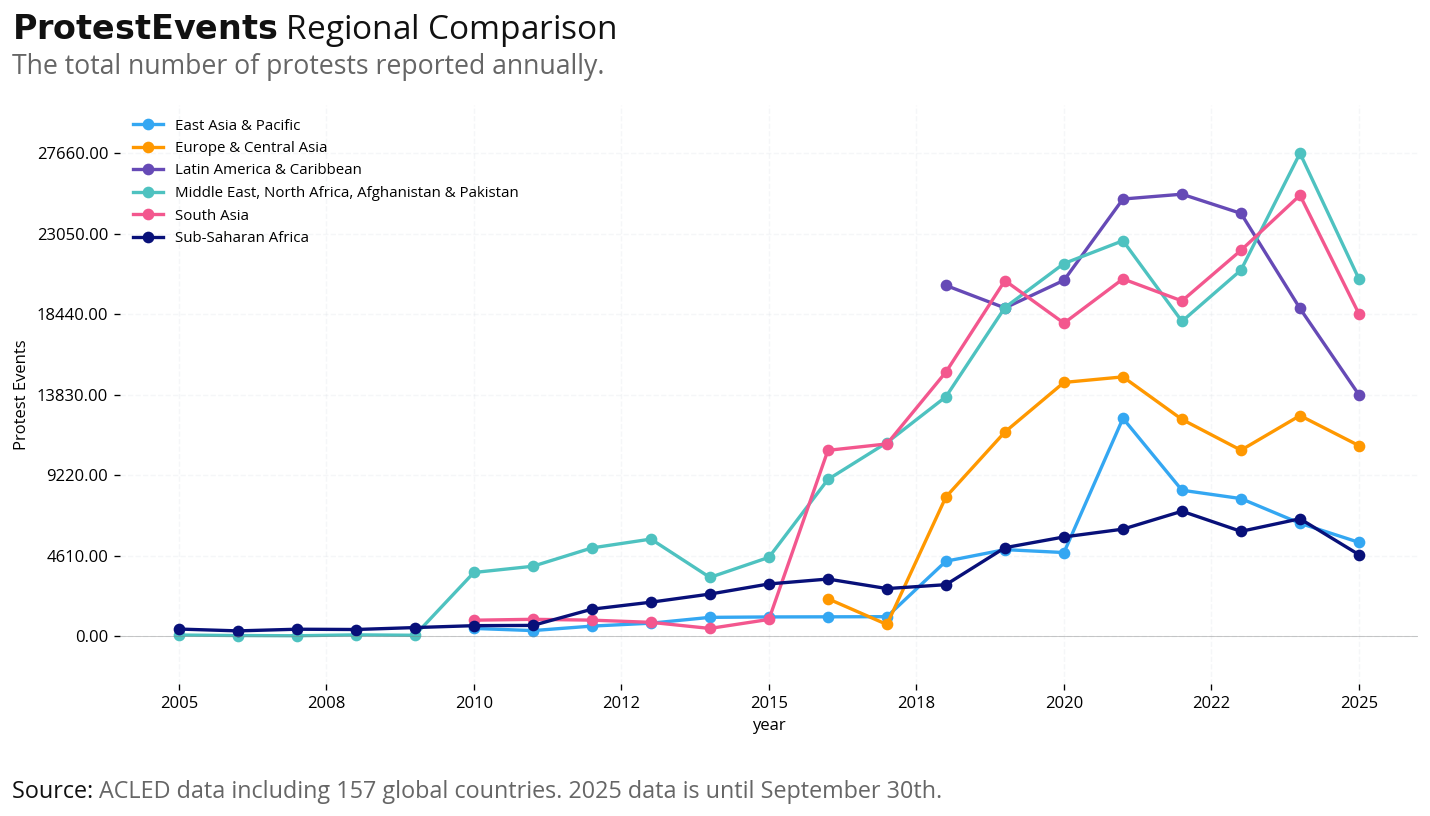

In [65]:
from visuals import *
indicator = 'Protest Events'
df = protests_region#[protests_region['wb_region']#.isin(['MEA', 'SSF', 'ECS', 'SAS', 'EAS'])]
plot_lines_wb(df[df['year']>=2005], line_col = 'region_name', x_col ='year', 
              value_col = indicator, 
              title = f'{str(indicator).replace(' ', '')} Regional Comparison',
              subtitle='The total number of protests reported annually.',
              note='ACLED data including 157 global countries. 2025 data is until September 30th.')

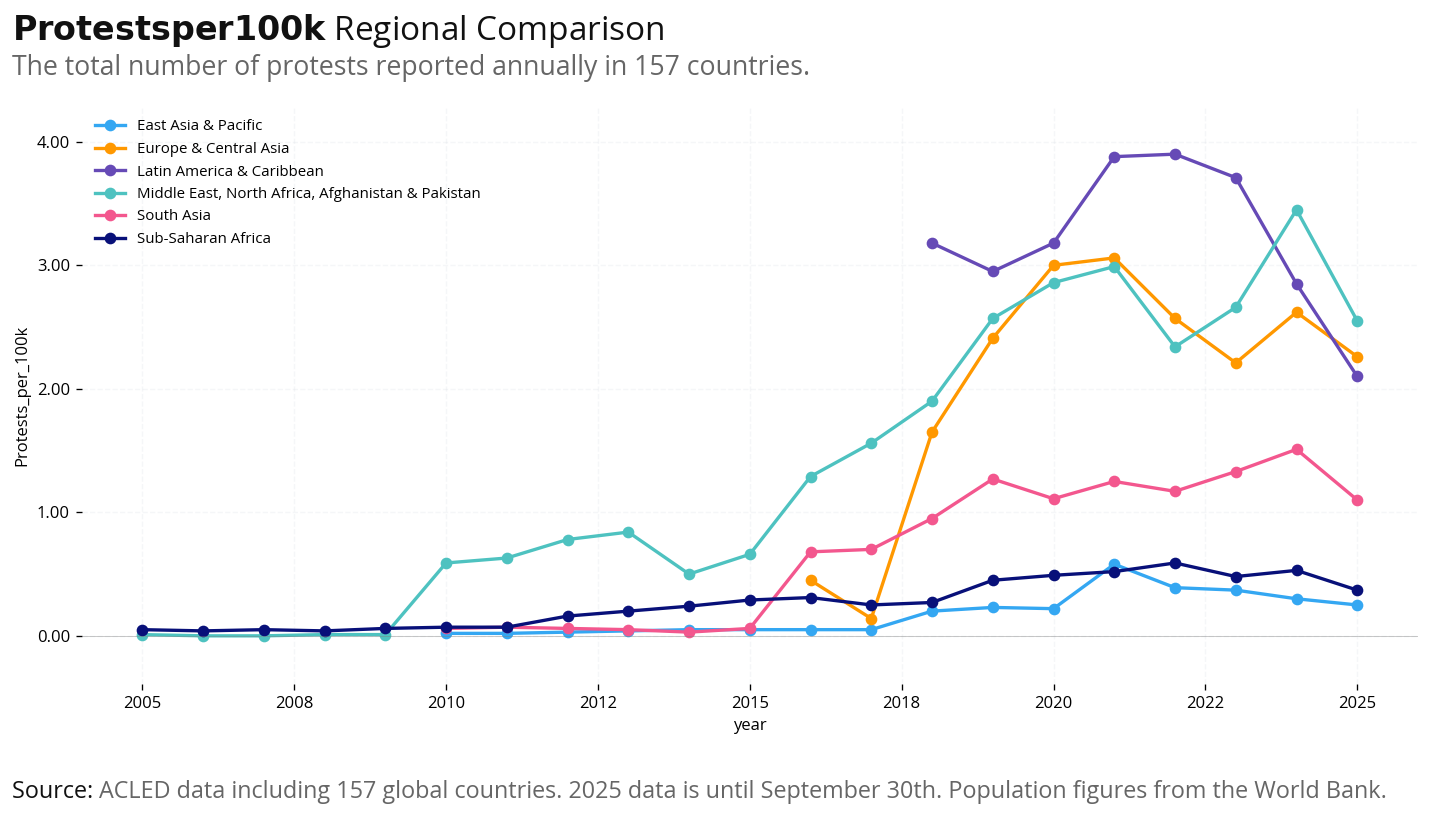

In [66]:
from visuals import *
indicator = 'Protests_per_100k'
df = protests_region_per_capita#[protests_region['wb_region']#.isin(['MEA', 'SSF', 'ECS', 'SAS', 'EAS'])]
plot_lines_wb(df[df['year']>=2005], line_col = 'region_name', x_col ='year', 
              value_col = indicator, 
              title = f'{str(indicator).replace('_', '')} Regional Comparison',
              subtitle='The total number of protests reported annually in 157 countries.',
              note='ACLED data including 157 global countries. 2025 data is until September 30th. Population figures from the World Bank.')

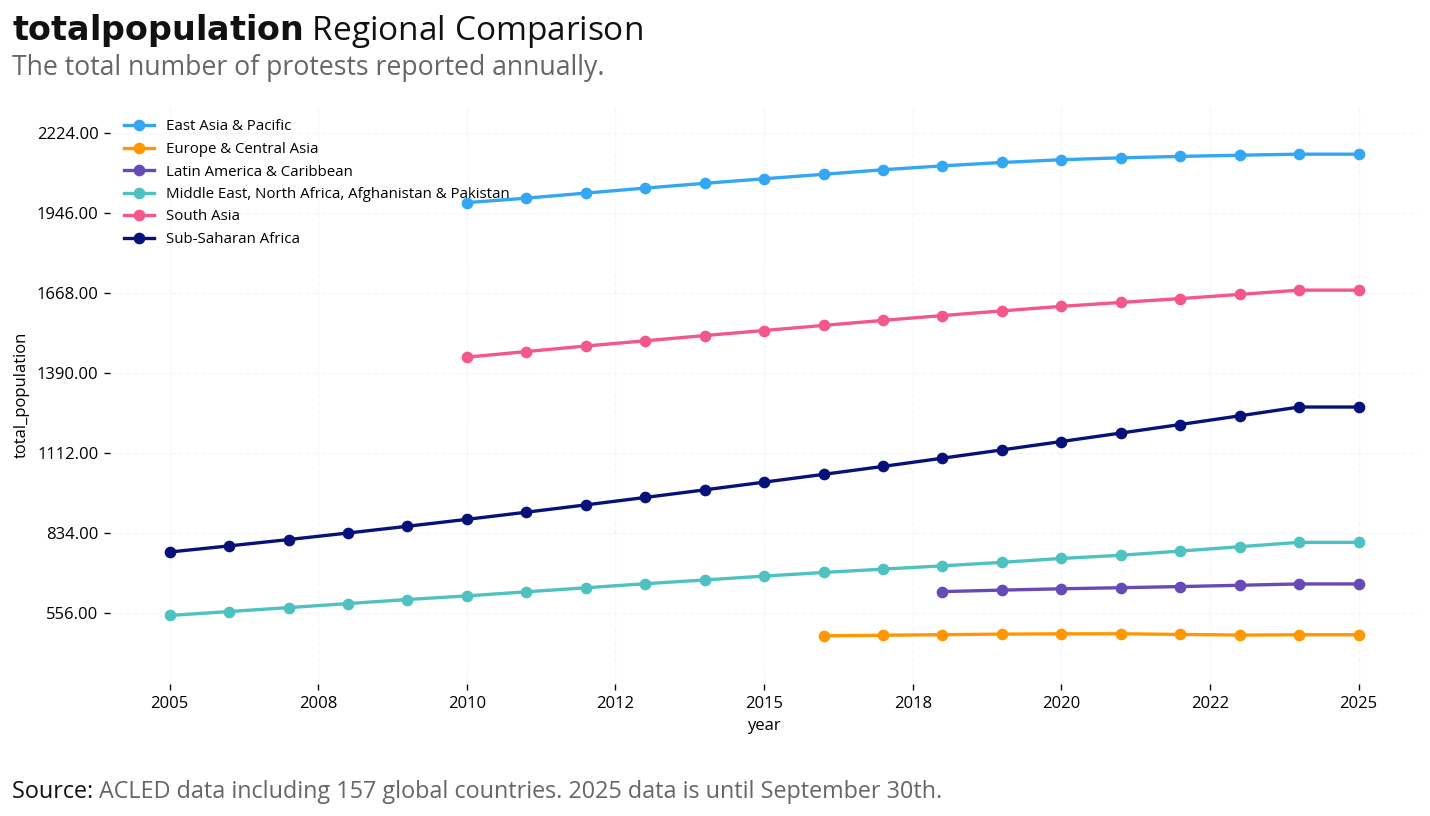

In [67]:
from visuals import *
indicator = 'total_population'
df = protests_region_per_capita#[protests_region['wb_region']#.isin(['MEA', 'SSF', 'ECS', 'SAS', 'EAS'])]
df['total_population'] = df['total_population']/1000000
plot_lines_wb(df[df['year']>=2005], line_col = 'region_name', x_col ='year', 
              value_col = indicator, 
              title = f'{str(indicator).replace('_', '')} Regional Comparison',
              subtitle='The total number of protests reported annually.',
              note='ACLED data including 157 global countries. 2025 data is until September 30th.')

In [68]:
protests_region_monthly['month'] = protests_region_monthly['event_date'].dt.month
protests_region_monthly['year_month'] = protests_region_monthly['year'].astype(str) + '-' + protests_region_monthly['month'].astype(str)

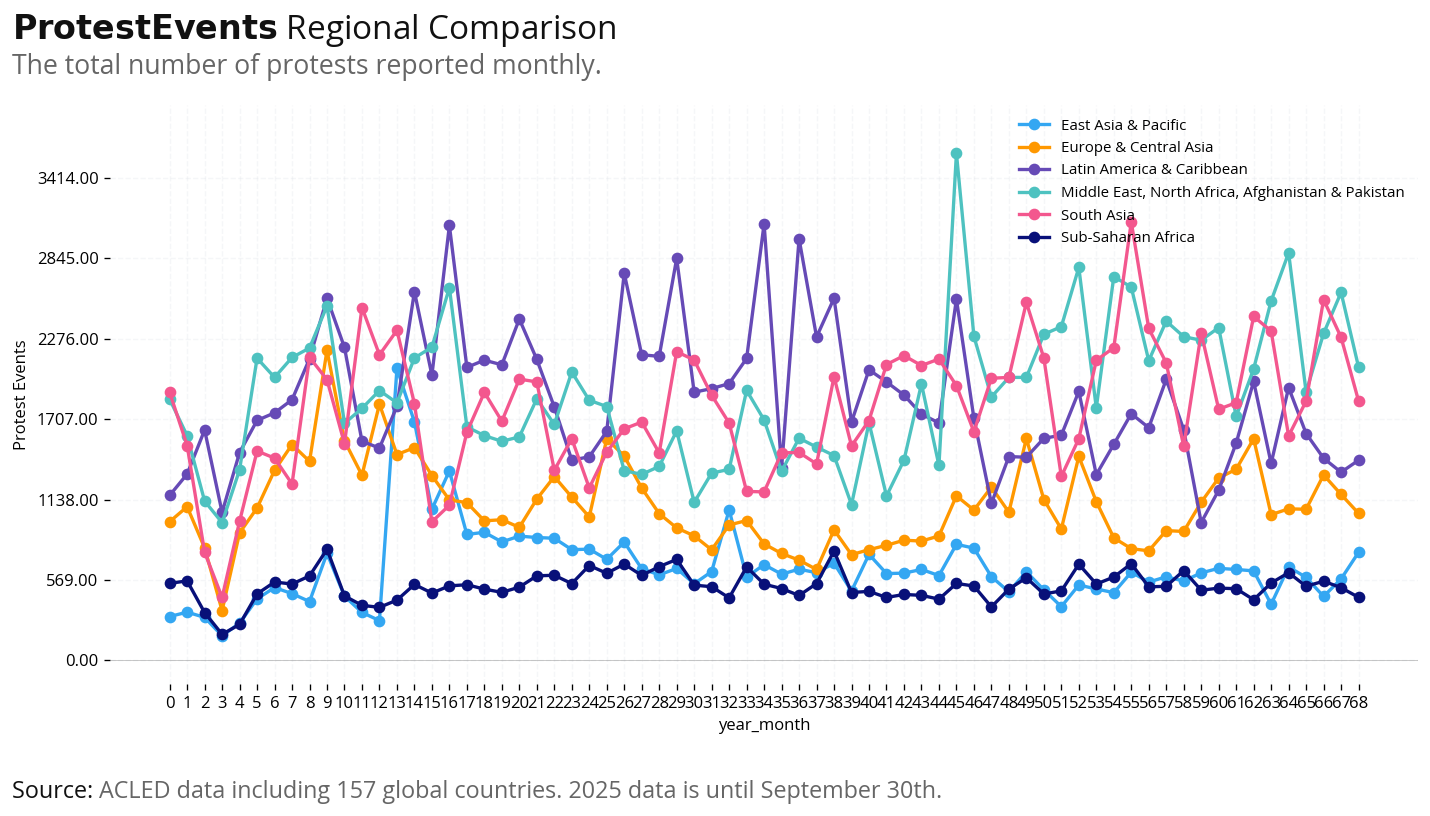

In [69]:
from visuals import *
indicator = 'Protest Events'
df = protests_region_monthly#[protests_region['wb_region']#.isin(['MEA', 'SSF', 'ECS', 'SAS', 'EAS'])]
plot_lines_wb(df[df['year']>=2020], line_col = 'region_name', x_col ='year_month', 
              value_col = indicator, 
              title = f'{str(indicator).replace(" ", "")} Regional Comparison',
              subtitle='The total number of protests reported monthly.',
              note='ACLED data including 157 global countries. 2025 data is until September 30th.')

In [70]:
mena_protests_sub_event = mena_protests.groupby(['country_name','sub_event_type', pd.Grouper(key='event_date', freq='YS')]).size().reset_index(name='nrEvents')

In [71]:
mena_protests.to_csv('../data/conflict/mena_protests.csv', index=False)

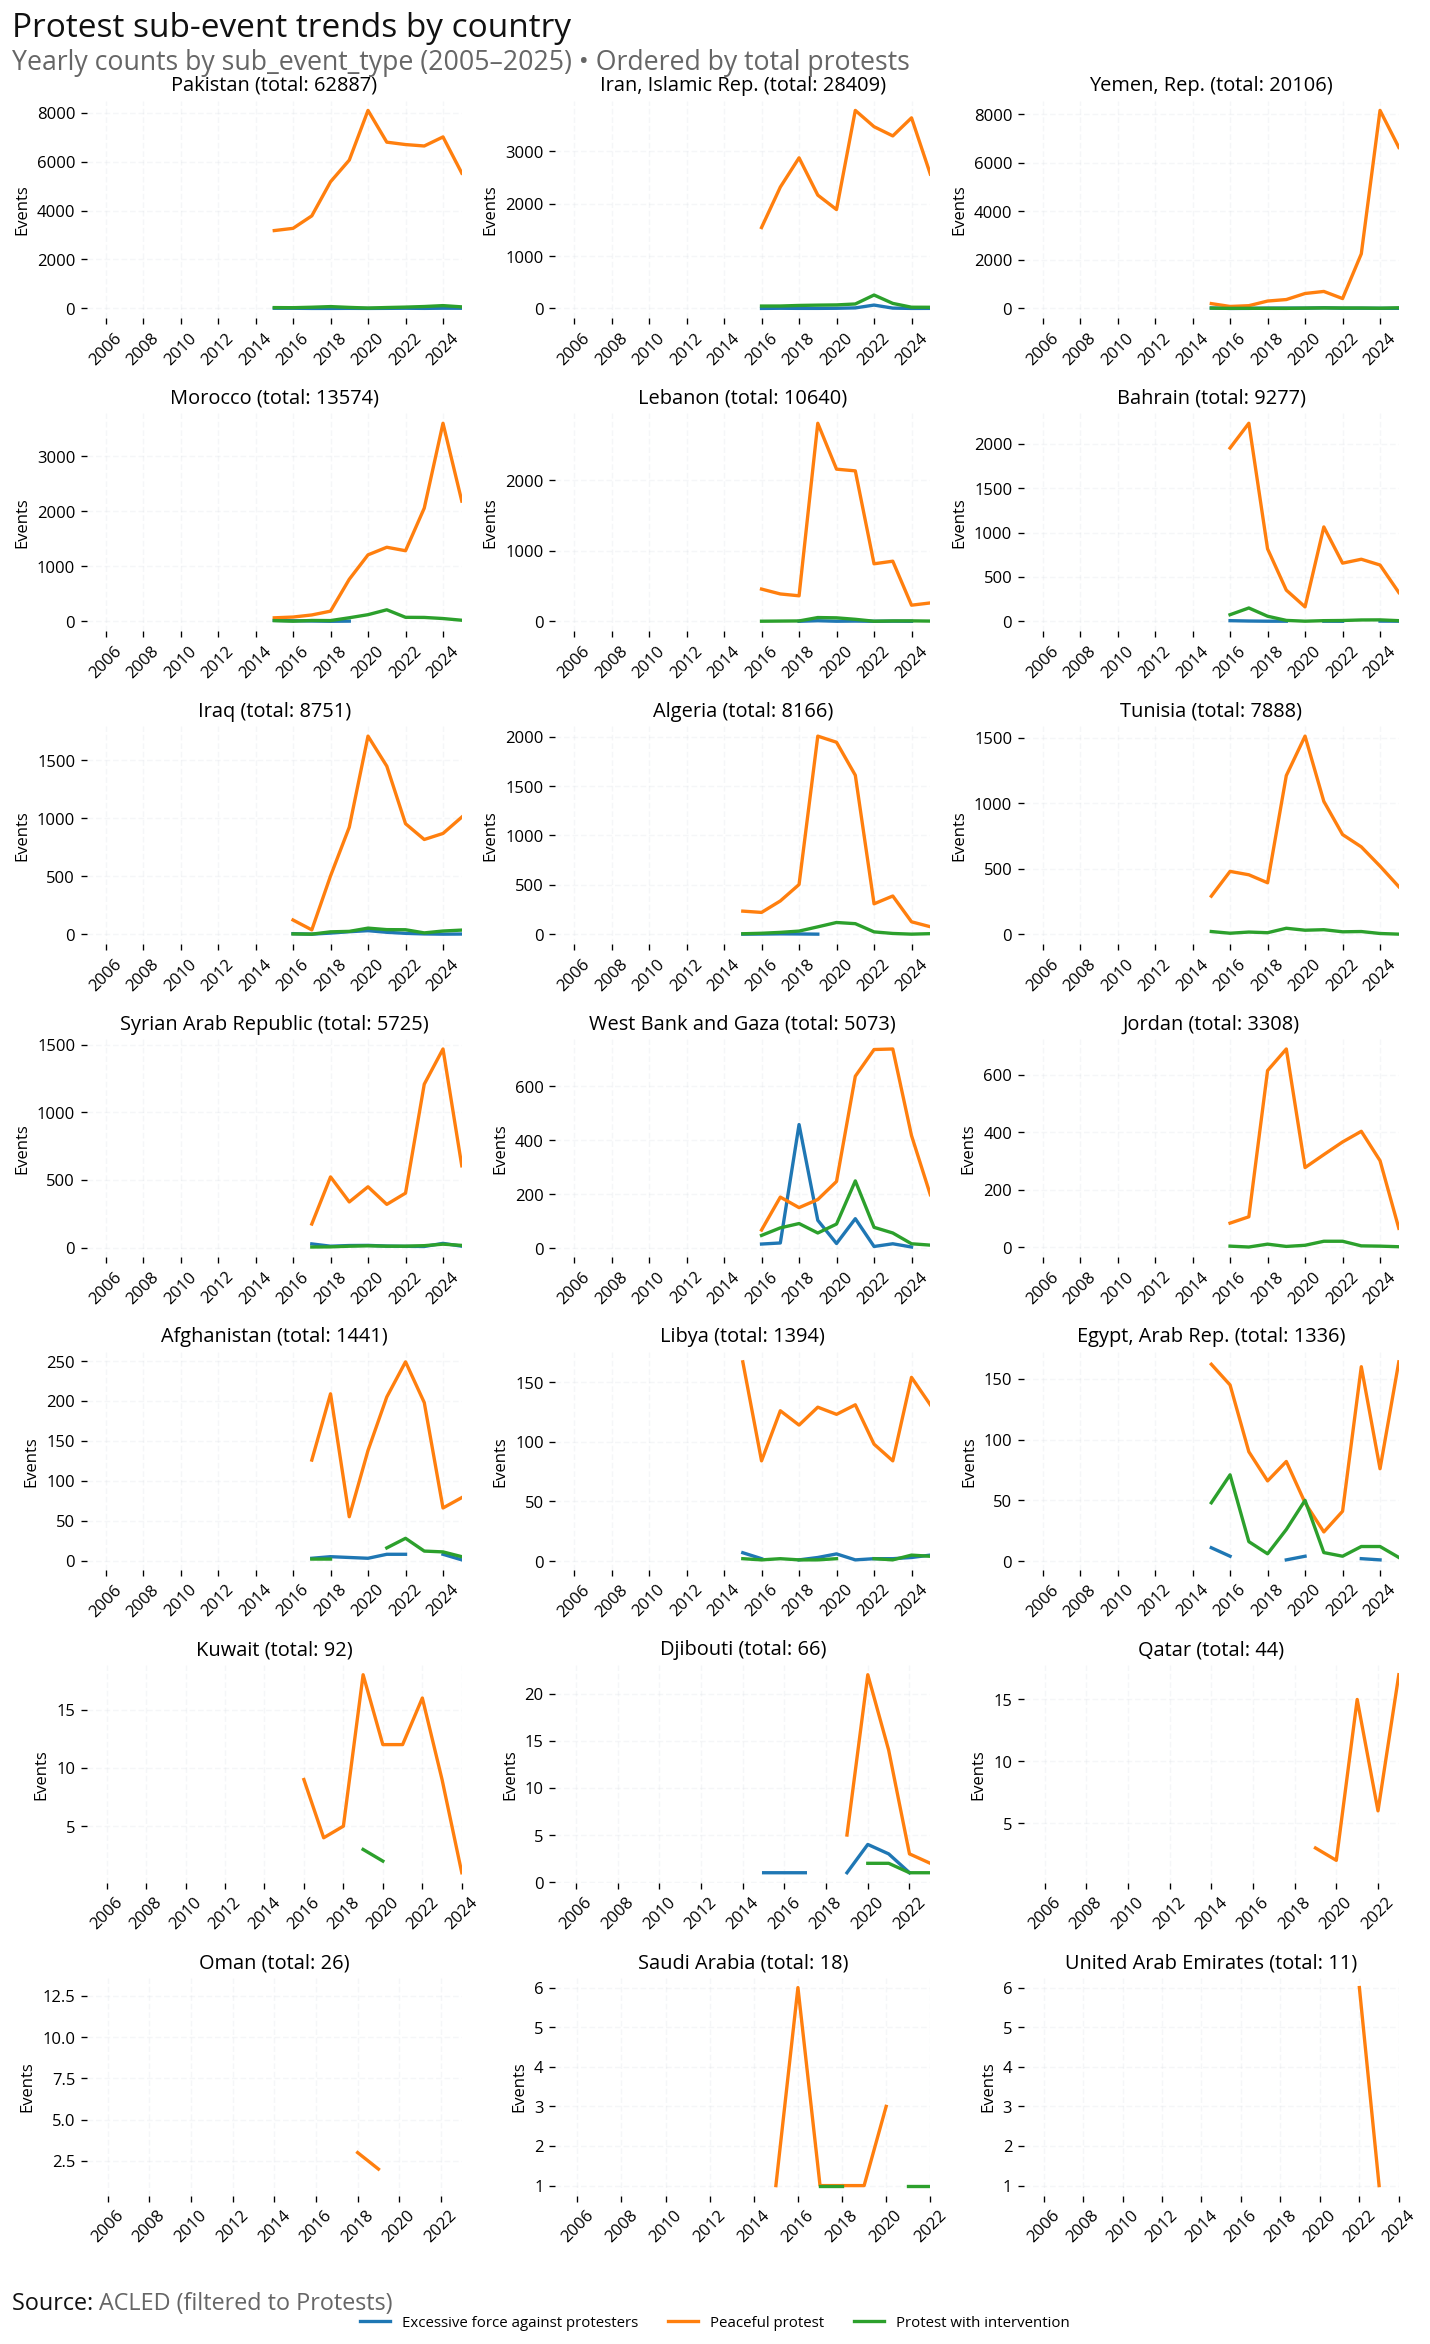

In [72]:
# Subplots: one panel per country, lines per sub_event_type with consistent colors
from wbpyplot import wb_plot
import seaborn as sns
import numpy as np

# Ensure consistent colors for sub_event types across all charts
sub_event_levels = sorted(mena_protests_sub_event['sub_event_type'].dropna().unique())
# Choose a palette large enough for all levels
base_palette = 'tab20' if len(sub_event_levels) > 10 else 'tab10'
colors = sns.color_palette(base_palette, n_colors=max(len(sub_event_levels), 10))
SUB_EVENT_COLORS = {lvl: colors[i % len(colors)] for i, lvl in enumerate(sub_event_levels)}


START_YEAR = 2005
START_TS = pd.Timestamp(f"{START_YEAR}-01-01")


def _plot_country_panel(ax, df_country, indicator_colors):
    # Build a complete yearly index from 2000 to the country's last year
    if df_country.empty:
        ax.set_axis_off()
        return
    last_ts = df_country['event_date'].max()
    full_idx = pd.date_range(start=START_TS, end=last_ts, freq='YS')

    # Pivot to wide and reindex to full range; keep NaN so gaps remain blank
    wide = (
        df_country
        .pivot_table(index='event_date', columns='sub_event_type', values='nrEvents', aggfunc='sum')
        .sort_index()
        .reindex(full_idx)
    )

    for col in sub_event_levels:
        if col in wide.columns:
            ax.plot(wide.index, wide[col], label=col, color=indicator_colors[col], linewidth=2)

    ax.grid(True, alpha=0.2)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim([START_TS, last_ts])


def plot_mena_protests_country_subplots(df, countries=None, ncols=4, top_n=None):
    df = df.copy()
    # Start from 2000; leave missing years as blank in plots
    df = df[df['event_date'] >= START_TS]

    # Order countries by total protest counts (descending) using filtered data
    country_totals = (
        df.groupby('country_name', dropna=True)['nrEvents']
          .sum()
          .sort_values(ascending=False)
    )
    all_countries_ordered = country_totals.index.tolist()

    if countries is None:
        countries = all_countries_ordered
    else:
        # Keep only requested countries, but ordered by totals
        requested = set(countries)
        countries = [c for c in all_countries_ordered if c in requested]

    if top_n is not None:
        countries = countries[:top_n]

    n = len(countries)
    if n == 0:
        print("No matching countries to plot.")
        return

    ncols_local = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols_local))

    title = "Protest sub-event trends by country"
    # Determine title range from filtered data
    if df['event_date'].empty:
        date_min = START_TS
        date_max = START_TS
    else:
        date_min = df['event_date'].min()
        date_max = df['event_date'].max()
    subtitle = f"Yearly counts by sub_event_type ({START_YEAR}–{date_max:%Y}) • Ordered by total protests"

    @wb_plot(
        title=title,
        subtitle=subtitle,
        note=[("Source:", "ACLED (filtered to Protests)")],
    )
    def _draw(axs):
        # Use the figure provided by decorator, re-create our grid
        fig = axs[0].figure if isinstance(axs, (list, tuple, np.ndarray)) else plt.gcf()
        fig.clf()
        fig.set_size_inches(max(12, 4 * ncols_local), max(8, 2.8 * nrows))
        axes = fig.subplots(nrows, ncols_local).reshape(-1)

        for i, country in enumerate(countries):
            ax = axes[i]
            df_country = df[df['country_name'] == country]
            if df_country.empty:
                ax.set_axis_off()
                continue
            _plot_country_panel(ax, df_country, SUB_EVENT_COLORS)
            total = int(country_totals.get(country, 0))
            ax.set_title(f"{country} (total: {total})")
            ax.set_ylabel('Events')

        # Hide any extra axes
        for j in range(len(countries), len(axes)):
            axes[j].set_visible(False)

        # Shared legend at bottom
        handles = [plt.Line2D([0], [0], color=SUB_EVENT_COLORS[l], lw=2, label=l) for l in sub_event_levels]
        fig.legend(handles=handles, labels=sub_event_levels, loc='lower center', ncol=min(4, len(sub_event_levels)), fontsize=9)
        plt.tight_layout(rect=[0, 0.08, 1, 1])

    _draw()

# Run for your MENA list, ordered by total protests
display_cols = 3
plot_mena_protests_country_subplots(mena_protests_sub_event, ncols=display_cols)

In [73]:
mena_protests.to_csv('../data/menaap_protests.csv')

## Protest Topics using Simple Word Cloud

This section performs text analysis on protest descriptions to understand what protesters are demanding and concerned about:

1. **Custom Stopwords**: We define domain-specific stopwords (common words like "protest", "demonstration", etc.) that don't reveal the actual issues protesters care about.

2. **Word Normalization**: Group related word forms together (e.g., "moroccan"/"moroccans" → "morocco") to get accurate counts of key concepts.

3. **Word Frequency Analysis**: Count the most common words after filtering stopwords and normalizing, revealing key themes like "government", "salary", "unemployment", "water", etc.

4. **Temporal Comparison**: Compare word clouds across three time periods (2015-2020, 2021-2024, 2025) to see how protest themes have evolved.

5. **Geographic Analysis**: Compare protest event counts by country across the same time periods to identify which countries have the most protest activity.

In [74]:
# Run this cell ONCE to download required NLTK data
import ssl
import certifi

# Set SSL context to unverified BEFORE any NLTK imports
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Now import NLTK
import nltk

# Download required NLTK data
print("Downloading NLTK data (with SSL verification disabled)...")

resources = [
    'stopwords',
    'punkt',
    'punkt_tab',  # Newer NLTK versions require this
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng',  # Newer version
    'omw-1.4'
]

for resource in resources:
    try:
        print(f"\nDownloading {resource}...")
        nltk.download(resource, quiet=False)
        print(f"✓ {resource} downloaded successfully")
    except Exception as e:
        print(f"✗ Error downloading {resource}: {e}")

print("\n✅ All NLTK data downloaded! You can now use the topic modeling utilities.")


✓ stopwords downloaded successfully

✓ punkt downloaded successfully



[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>


✓ punkt_tab downloaded successfully

✓ wordnet downloaded successfully

✓ averaged_perceptron_tagger downloaded successfully

✓ averaged_perceptron_tagger_eng downloaded successfully

✓ omw-1.4 downloaded successfully

✅ All NLTK data downloaded! You can now use the topic modeling utilities.
✓ averaged_perceptron_tagger_eng downloaded successfully

✓ omw-1.4 downloaded successfully

✅ All NLTK data downloaded! You can now use the topic modeling utilities.


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1077)>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [SSL: CERTIFICATE_VERIFY_FAILED] certificate
[nltk_data]     verify failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1077)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1077)>


In [75]:
# Define custom stopwords for protest analysis
# These are common words in protest descriptions that don't add meaningful information

custom_stopwords = [
    # Generic protest terms
    'protest', 'protester', 'protesters', 'demonstration', 'demonstrator', 'demonstrators',
    'rally', 'march', 'marched', 'marching', 'gathered', 'gathering','cause', 'movement', 'movement','sit-in','sit ins','sit in',
    
    # Common report words
    'report', 'reported', 'reporting', 'according', 'source', 'sources',
    
    # Location/time words (if not informative)
    'area', 'location', 'place', 'time', 'day', 'week', 'month', 'year',
    'today', 'yesterday', 'recently', 'months', 'county',
    
    # Action words (common verbs in protest descriptions)
    'took', 'take', 'taken', 'taking',
    'made', 'make', 'making',
    'held', 'hold', 'holding',
    'called', 'call', 'calling',
    'said', 'say', 'saying',
    'stated', 'state', 'stating',
    'claimed', 'claim', 'claiming',
    'demanded', 'demand', 'demanding',
    'gathered', 'gather', 'gathering',
    'rallied', 'rally', 'rallying',
    'marched', 'march', 'marching',
    'protested', 'protest', 'protesting',
    'chanted', 'chant', 'chanting', 'chants',
    'staged', 'stage', 'staging',
    'organized', 'organize', 'organizing',
    'participated', 'participate', 'participating',
    'attended', 'attend', 'attending',
    'joined', 'join', 'joining',
    'blocked', 'block', 'blocking',
    'opposed', 'oppose', 'opposing',
    'supported', 'support', 'supporting',
    'condemned', 'condemn', 'condemning',
    'criticized', 'criticize', 'criticizing',
    'denounced', 'denounce', 'denouncing',
    'expressed', 'express', 'expressing',
    'voiced', 'voice', 'voicing',
    'demonstrated', 'demonstrate', 'demonstrating',
    'assembled', 'assemble', 'assembling',
    'convened', 'convene', 'convening',
    'coordinated', 'coordinate', 'coordinating',
    'followed', 'follow', 'following',
    'continued', 'continue', 'continuing', 'ongoing',
    'called', 'call', 'calling','case','protest',

    
    # Numbers and determiners (if not removed already)
    'one', 'two', 'three', 'several', 'many', 'number', 'group', 'groups',
    
    # ACLED-specific terms
    'event', 'events', 'acled', 'data','coded',
    
    # Common but uninformative words
    'people', 'person', 'individual', 'individuals',
    'also', 'however', 'although', 'though', 'great', 'front', 
    'district', 'tehran', 'iran', 'resident', 'residents', 
    'isfahan', 'city', 'local', 'khuzestan', 'near', 'outside',
    'office', 'province', 'building', 'organization', 'provincial',
    'regarding', 'central', 'institution', 'ground',
    'protesters', 'slogans', 'friday', 'anti', 'recent', 'lack',
    'activists', 'activity', 'activities', 'security', 'forces',
    'large', 'small', 'several', 'various', 'numerous','round',
    'part', 'members', 'member', 'team', 'unit', 'units',"context",'town', 'city','civil', 'society',

    # Month names
    'january', 'february', 'march', 'april', 'may', 'june', 'club', 
    'july', 'august', 'september', 'october', 'november', 'december','s', 'al', 'sit', 'latest', 'actions',
    'across','u','government','including','end',

    # Places
    'sindh', 'karachi', 'lahore', 'punjab',

    # Prepositions and common function words
    'in', 'on', 'at', 'to', 'for', 'of', 'with', 'from', 'by', 'about', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'between', 'under', 'over', 'around',
    'within', 'without', 'against', 'among', 'towards', 'upon', 'behind', 'beside',
    'throughout', 'amid', 'via', 'per', 'till', 'until', 'since',

    # Politically Charged words
    'zionist', 'zionism', 'morocco','moroccan', 'road', 'roads', 'street', 'streets', 'dozen', 'dozens',
    
    # Additional stopwords
    'national', 'start', 'started', 'starting', 'starts',
    
    # Add your own domain-specific stopwords here
    # Example: 'covid', 'pandemic' if not relevant to your analysis
]

print(f"Defined {len(custom_stopwords)} custom stopwords for protest analysis")
print("You can add or remove words from this list based on your needs")

Defined 290 custom stopwords for protest analysis
You can add or remove words from this list based on your needs


In [76]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

lemmatizer = WordNetLemmatizer()



def generate_word_cloud_from_column(df, column_name, custom_stopwords):
    # Combine all the text in the specified column into a single string
    text = " ".join(note for note in df[column_name])

    stopwords = set(STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)  

    # Generate the word cloud
     # Generate the word cloud, excluding the stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords  # Pass the stopwords set here
    ).generate(text)


    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide the axes
    plt.show()


def get_word_counts(df, column_name, custom_stopwords):

    # Word normalization dictionary - maps variations to canonical form
    # This groups related words like morocco/moroccan, palestine/palestinian
    word_normalizations = {
        'moroccan': 'morocco',
        'moroccans': 'morocco',
        'palestinian': 'palestine',
        'palestinians': 'palestine',
        'israeli': 'israel',
        'israelis': 'israel',
        'egyptian': 'egypt',
        'egyptians': 'egypt',
        'iraqi': 'iraq',
        'iraqis': 'iraq',
        'syrian': 'syria',
        'syrians': 'syria',
        'lebanese': 'lebanon',
        'yemeni': 'yemen',
        'yemenis': 'yemen',
        'tunisian': 'tunisia',
        'tunisians': 'tunisia',
        'algerian': 'algeria',
        'algerians': 'algeria',
        'libyan': 'libya',
        'libyans': 'libya',
        'jordanian': 'jordan',
        'jordanians': 'jordan',
        'afghan': 'afghanistan',
        'afghans': 'afghanistan',
        'pakistani': 'pakistan',
        'pakistanis': 'pakistan',
        'saudi': 'saudi arabia',
        'saudis': 'saudi arabia',
        'emirati': 'uae',
        'emiratis': 'uae',
        # Add more as needed
        'salaries': 'salary',
        'retirees': 'retirement',
        'retired': 'retirement',
    }
    
    text = " ".join(note for note in df[column_name])
    words = re.findall(r'\b\w+\b', text.lower())

    wordcloud_stopwords = STOPWORDS
    all_stopwords = wordcloud_stopwords.union(custom_stopwords)
    all_stopwords_lower = {word.lower() for word in all_stopwords}

    # Filter out stopwords and numeric values
    filtered_words = [
        word for word in words 
        if word.lower() not in all_stopwords_lower and not word.isnumeric()
    ]
    
    # Use lemmatization instead of stemming to preserve word forms better
    # This keeps nouns like "workers" separate from verbs like "working"
    # Lemmatization respects part of speech, so it won't over-reduce words
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in filtered_words]
    
    # Apply word normalizations to group related terms
    normalized_words = [word_normalizations.get(word, word) for word in lemmatized_words]

    # Count the occurrences of each normalized word
    word_counts = Counter(normalized_words)

    # Create DataFrame
    word_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    word_count_df = word_count_df.sort_values(by='Count', ascending=False)

    return word_count_df


def get_ngram_counts(df, column_name, custom_stopwords, n=2, top_n=50):
    """
    Extract n-grams (phrases of n words) from text column.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    column_name : str
        Name of text column
    custom_stopwords : list
        Custom stopwords to filter
    n : int
        Number of words in phrase (2=bigrams, 3=trigrams)
    top_n : int
        Number of top results to return
        
    Returns:
    --------
    DataFrame with ngram phrases and their counts
    """
    from nltk import word_tokenize
    
    all_ngrams = []
    
    # Process each row separately to maintain phrase boundaries
    for text in df[column_name].dropna():
        text = str(text).lower()
        
        # Tokenize properly
        words = word_tokenize(text)
        
        # Filter stopwords and non-alphabetic
        wordcloud_stopwords = STOPWORDS
        all_stopwords = wordcloud_stopwords.union(custom_stopwords)
        all_stopwords_lower = {word.lower() for word in all_stopwords}
        
        filtered_words = [
            word for word in words 
            if word.isalpha() and word not in all_stopwords_lower and len(word) > 2
        ]
        
        # Generate n-grams
        if len(filtered_words) >= n:
            text_ngrams = list(ngrams(filtered_words, n))
            all_ngrams.extend(text_ngrams)
    
    # Count n-grams
    ngram_counts = Counter(all_ngrams)
    
    # Create DataFrame
    ngram_df = pd.DataFrame(
        [(' '.join(ngram), count) for ngram, count in ngram_counts.most_common(top_n)],
        columns=['Phrase', 'Count']
    )
    
    return ngram_df


def get_collocations(df, column_name, custom_stopwords, n=2, top_n=50, min_freq=5):
    """
    Find collocations (words that frequently occur together) using statistical measures.
    This is more sophisticated than simple n-gram counting - it finds words that 
    appear together more often than would be expected by chance.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    column_name : str
        Name of text column
    custom_stopwords : list
        Custom stopwords to filter
    n : int
        2 for bigrams, 3 for trigrams
    top_n : int
        Number of top results to return
    min_freq : int
        Minimum frequency threshold
        
    Returns:
    --------
    DataFrame with collocations and their PMI scores
    """
    from nltk import word_tokenize
    
    # Combine all text
    all_words = []
    
    for text in df[column_name].dropna():
        text = str(text).lower()
        words = word_tokenize(text)
        
        # Filter
        wordcloud_stopwords = STOPWORDS
        all_stopwords = wordcloud_stopwords.union(custom_stopwords)
        all_stopwords_lower = {word.lower() for word in all_stopwords}
        
        filtered = [
            word for word in words 
            if word.isalpha() and word not in all_stopwords_lower and len(word) > 2
        ]
        all_words.extend(filtered)
    
    # Find collocations
    if n == 2:
        finder = BigramCollocationFinder.from_words(all_words)
        finder.apply_freq_filter(min_freq)
        # Use PMI (Pointwise Mutual Information) - measures how much more likely 
        # words are to occur together vs independently
        scored = finder.score_ngrams(BigramAssocMeasures.pmi)
    else:  # n == 3
        finder = TrigramCollocationFinder.from_words(all_words)
        finder.apply_freq_filter(min_freq)
        scored = finder.score_ngrams(TrigramAssocMeasures.pmi)
    
    # Create DataFrame
    results = []
    for ngram, score in scored[:top_n]:
        phrase = ' '.join(ngram)
        # Get actual frequency
        freq = finder.ngram_fd[ngram]
        results.append((phrase, freq, round(score, 2)))
    
    colloc_df = pd.DataFrame(results, columns=['Phrase', 'Frequency', 'PMI_Score'])
    
    return colloc_df

## Debug: Why "dozen" isn't filtered

The issue is likely one of these:

1. **Processing Order**: We filter stopwords BEFORE lemmatization, but "dozens" → "dozen" during lemmatization happens AFTER filtering
2. **Variant Forms**: The text might contain "dozens", "dozen's", or other variants
3. **Case Issues**: Though we handle case conversion

**Solution**: We should lemmatize BEFORE checking stopwords, not after.

In [77]:
def get_word_counts_improved(df, column_name, custom_stopwords):
    """
    Improved word count function with proper processing order:
    1. Tokenize
    2. Clean & lemmatize 
    3. Check stopwords (on cleaned forms)
    4. Normalize
    """
    
    # Word normalization dictionary - same as before
    word_normalizations = {
        'moroccan': 'morocco', 'moroccans': 'morocco',
        'palestinian': 'palestine', 'palestinians': 'palestine',
        'israeli': 'israel', 'israelis': 'israel',
        'egyptian': 'egypt', 'egyptians': 'egypt',
        'iraqi': 'iraq', 'iraqis': 'iraq',
        'syrian': 'syria', 'syrians': 'syria',
        'lebanese': 'lebanon',
        'yemeni': 'yemen', 'yemenis': 'yemen',
        'tunisian': 'tunisia', 'tunisians': 'tunisia',
        'algerian': 'algeria', 'algerians': 'algeria',
        'libyan': 'libya', 'libyans': 'libya',
        'jordanian': 'jordan', 'jordanians': 'jordan',
        'afghan': 'afghanistan', 'afghans': 'afghanistan',
        'pakistani': 'pakistan', 'pakistanis': 'pakistan',
        'saudi': 'saudi arabia', 'saudis': 'saudi arabia',
        'emirati': 'uae', 'emiratis': 'uae',
        'salaries': 'salary',
        'retirees': 'retirement', 'retired': 'retirement',
    }
    
    text = " ".join(note for note in df[column_name])
    words = re.findall(r'\b\w+\b', text.lower())

    # Prepare stopwords
    wordcloud_stopwords = STOPWORDS
    all_stopwords = wordcloud_stopwords.union(custom_stopwords)
    all_stopwords_lower = {word.lower() for word in all_stopwords}
    
    processed_words = []
    
    for word in words:
        # Skip numeric values
        if word.isnumeric():
            continue
            
        # Lemmatize first (this converts "dozens" → "dozen")
        lemmatized = lemmatizer.lemmatize(word, pos='n')
        
        # Then check stopwords on the lemmatized form
        if lemmatized.lower() in all_stopwords_lower:
            continue
            
        # Apply normalizations
        normalized = word_normalizations.get(lemmatized, lemmatized)
        processed_words.append(normalized)

    # Count the occurrences
    word_counts = Counter(processed_words)

    # Create DataFrame
    word_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    word_count_df = word_count_df.sort_values(by='Count', ascending=False)

    return word_count_df

print("✓ Improved word count function created - lemmatizes BEFORE stopword filtering")

✓ Improved word count function created - lemmatizes BEFORE stopword filtering


In [78]:
# Test the improved function with Morocco data
print("Testing improved word count function...")
print("="*50)

# Test with a small sample to debug
test_mor_wc = get_word_counts_improved(morocco_2015_2020.head(100), 'notes', custom_stopwords + morocco_custom)

print("Top 20 words from improved function:")
print(test_mor_wc.head(20))

# Check if "dozen" appears
if "dozen" in test_mor_wc['Word'].values:
    dozen_count = test_mor_wc[test_mor_wc['Word'] == 'dozen']['Count'].iloc[0]
    print(f"\n❌ 'dozen' still appears with count: {dozen_count}")
else:
    print(f"\n✅ 'dozen' successfully filtered out!")

print("\nComparing with original function:")
test_mor_wc_original = get_word_counts(morocco_2015_2020.head(100), 'notes', custom_stopwords + morocco_custom)
if "dozen" in test_mor_wc_original['Word'].values:
    dozen_count_orig = test_mor_wc_original[test_mor_wc_original['Word'] == 'dozen']['Count'].iloc[0]
    print(f"❌ Original function: 'dozen' appears with count: {dozen_count_orig}")
else:
    print(f"✅ Original function: 'dozen' filtered out!")

Testing improved word count function...
Top 20 words from improved function:
               Word  Count
1            jerada     32
2          economic     28
5              died     27
0          thousand     26
8              mine     26
3   marginalisation     26
7              coal     24
6           digging     23
10              men     19
9             young     18
11        abandoned     18
19              rif     14
20           region     12
14           slogan     12
15            hirak     12
18     neighbouring     11
72            force     11
13          adopted     11
17           string     11
16           shaabi     11

✅ 'dozen' successfully filtered out!

Comparing with original function:
✅ Original function: 'dozen' filtered out!


In [79]:
mena_protests_2015_2020 = mena_protests[mena_protests['event_date'].dt.year.isin([2015, 2016, 2017, 2018, 2019, 2020])]
mena_protests_2021_2024 = mena_protests[mena_protests['event_date'].dt.year.isin([2021, 2022, 2023, 2024])]
mena_protests_2025 = mena_protests[mena_protests['event_date'].dt.year.isin([2025])]

In [80]:
# Word normalization dictionary for topic modeling
# This groups related words like morocco/moroccan, palestine/palestinian
word_normalizations = {
    'moroccan': 'morocco',
    'moroccans': 'morocco',
    'palestinian': 'palestine',
    'palestinians': 'palestine',
    'israeli': 'israel',
    'israelis': 'israel',
    'egyptian': 'egypt',
    'egyptians': 'egypt',
    'iraqi': 'iraq',
    'iraqis': 'iraq',
    'syrian': 'syria',
    'syrians': 'syria',
    'lebanese': 'lebanon',
    'yemeni': 'yemen',
    'yemenis': 'yemen',
    'tunisian': 'tunisia',
    'tunisians': 'tunisia',
    'algerian': 'algeria',
    'algerians': 'algeria',
    'libyan': 'libya',
    'libyans': 'libya',
    'jordanian': 'jordan',
    'jordanians': 'jordan',
    'afghan': 'afghanistan',
    'afghans': 'afghanistan',
    'pakistani': 'pakistan',
    'pakistanis': 'pakistan',
    'saudi': 'saudi arabia',
    'saudis': 'saudi arabia',
    'emirati': 'uae',
    'emiratis': 'uae',
    'salaries': 'salary',
    'retirees': 'retirement',
    'retired': 'retirement',
}


print(f"Defined {len(word_normalizations)} word normalization mappings for topic modeling")

Defined 34 word normalization mappings for topic modeling


In [81]:
word_counts_2015_2020 = get_word_counts(mena_protests_2015_2020, 'notes', custom_stopwords)
word_counts_2021_2024 = get_word_counts(mena_protests_2021_2024, 'notes', custom_stopwords)
word_counts_2025 = get_word_counts(mena_protests_2025, 'notes', custom_stopwords)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


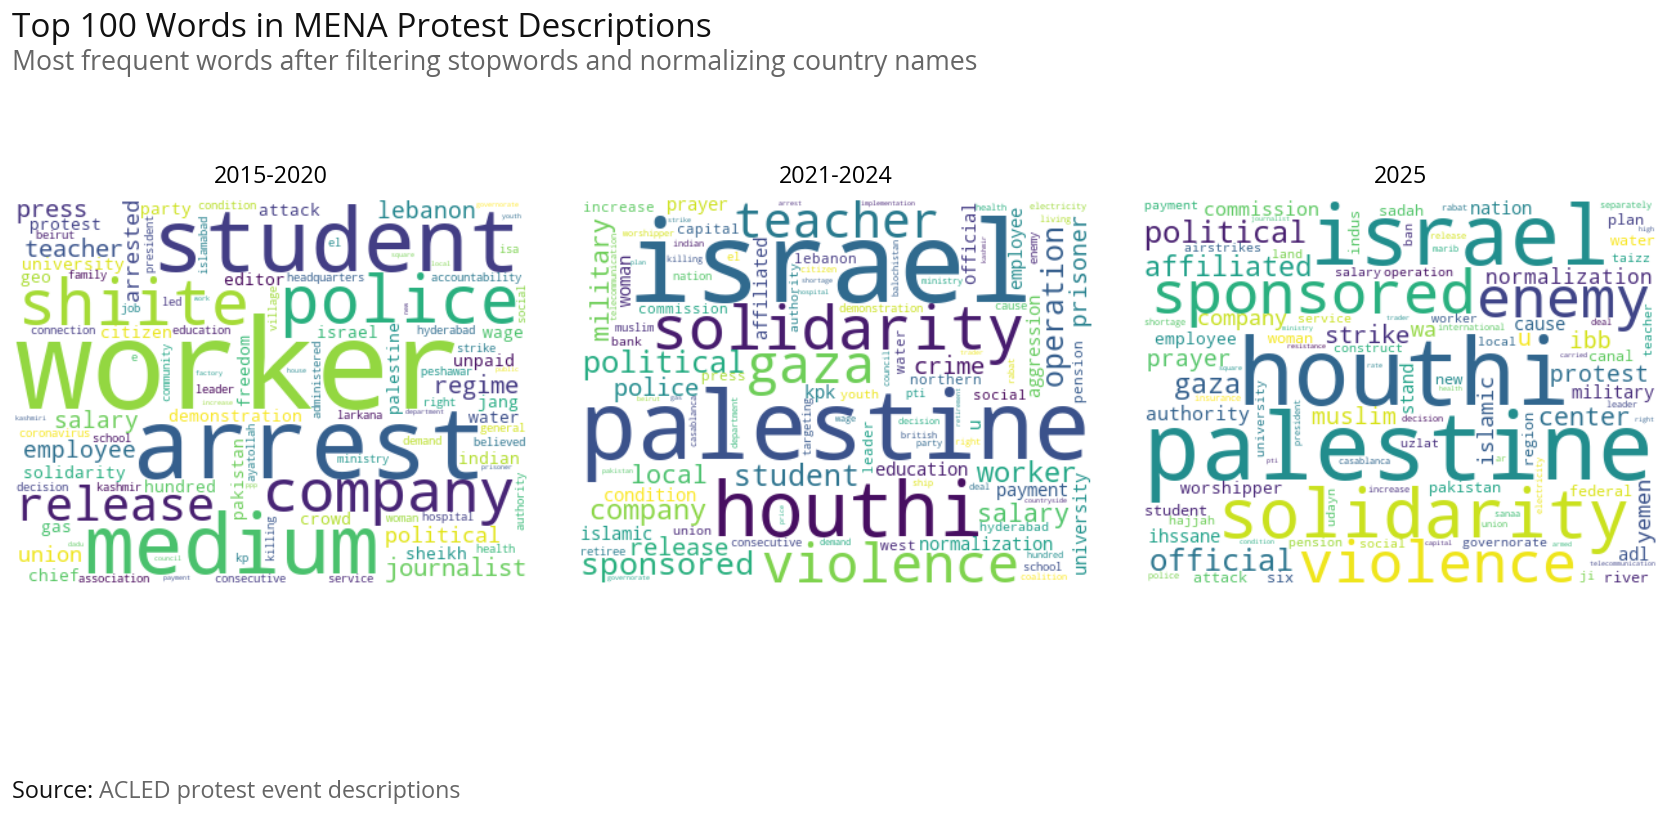

In [82]:
# Create word cloud comparison using the new function
from visuals import *

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

n=100
word_freq_1 = dict(zip(word_counts_2015_2020['Word'][:n], word_counts_2015_2020['Count'][:n]))
word_freq_2 = dict(zip(word_counts_2021_2024['Word'][:n], word_counts_2021_2024['Count'][:n]))
word_freq_3 = dict(zip(word_counts_2025['Word'][:n], word_counts_2025['Count'][:n]))

plot_wordcloud_comparison(
    word_freq_dicts=[word_freq_1, word_freq_2, word_freq_3],
    subplot_titles=['2015-2020', '2021-2024', '2025'],
    main_title=f'Top {n} Words in MENA Protest Descriptions',
    subtitle='Most frequent words after filtering stopwords and normalizing country names',
    note='ACLED protest event descriptions',
    figsize=(14, 7),
    ncols=3
);

In [83]:
mena_2015_2020 = protests_country[(protests_country['wb_region']=='MEA')&(protests_country['year']>=2015)&(protests_country['year']<=2020)].groupby(['country_name'])['Protest Events'].sum().reset_index()
mena_2021_2024 = protests_country[(protests_country['wb_region']=='MEA')&(protests_country['year']>=2021)&(protests_country['year']<=2024)].groupby(['country_name'])['Protest Events'].sum().reset_index()
mena_2025 = protests_country[(protests_country['wb_region']=='MEA')&(protests_country['year']==2025)].groupby(['country_name'])['Protest Events'].sum().reset_index()

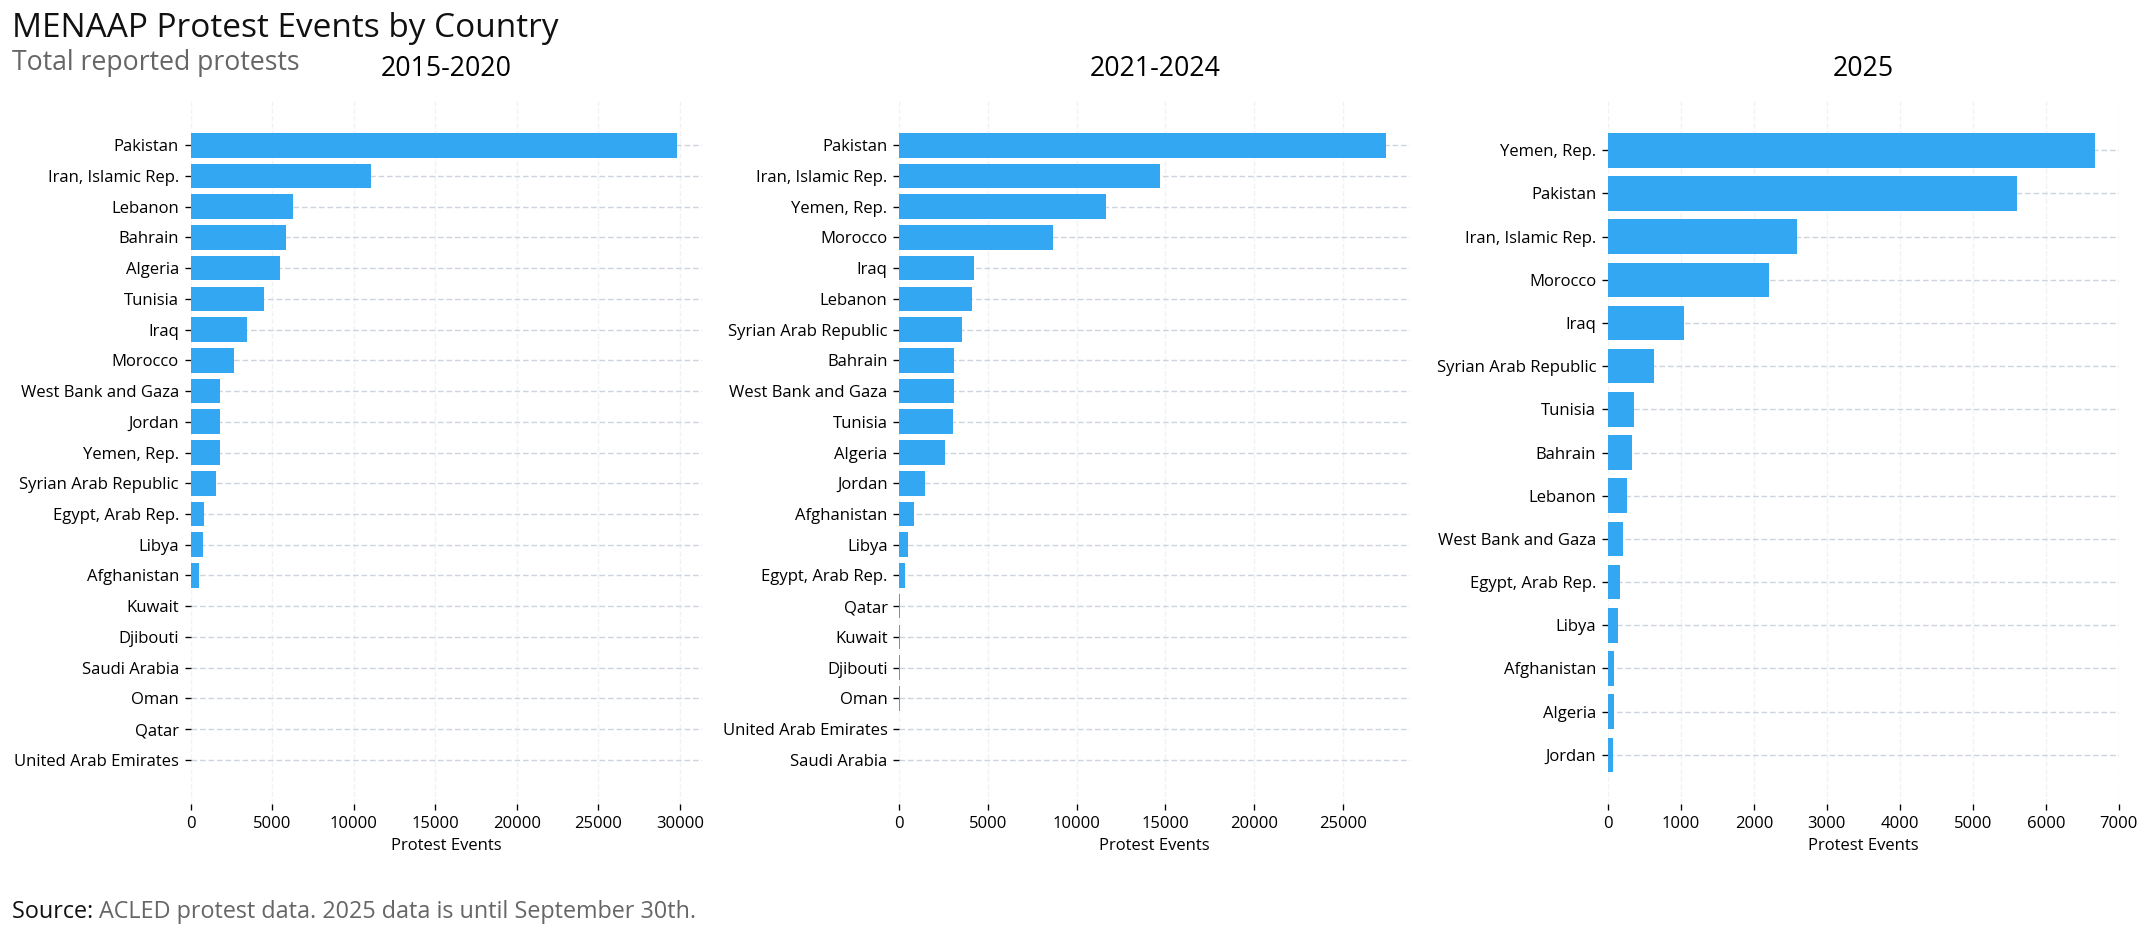

In [84]:
from visuals import plot_horizontal_bar_comparison

plot_horizontal_bar_comparison(
    dataframes=[mena_2015_2020, mena_2021_2024, mena_2025],
    value_col='Protest Events',
    label_col='country_name',
    subplot_titles=['2015-2020', '2021-2024', '2025'],
    main_title='MENAAP Protest Events by Country',
    subtitle='Total reported protests',
    note='ACLED protest data. 2025 data is until September 30th.',
    figsize=(18, 8),
    sort_ascending=True
)

In [85]:
morocco = mena_protests[mena_protests['country_name']=='Morocco']
morocco_2015_2020 = morocco[morocco['event_date'].dt.year.isin([2015, 2016, 2017, 2018, 2019, 2020])]
morocco_2021_2024 = morocco[morocco['event_date'].dt.year.isin([2021, 2022, 2023, 2024])]
morocco_2025 = morocco[morocco['event_date'].dt.year.isin([2025])]

In [86]:
morocco_custom = ['casablanca', 'casablanca', 'rabat', 'morocco', 
                  'moroccan', 'moroccans', 'protest', 'protests', 'protester', 'protesters', 'dozen', 'dozens', 'el', 'cause', 'marrakech']

In [87]:
mor_wc_2015_2020 = get_word_counts(morocco_2015_2020, 'notes', custom_stopwords+morocco_custom)
mor_wc_2021_2024 = get_word_counts(morocco_2021_2024, 'notes', custom_stopwords+morocco_custom)
mor_wc_2025 = get_word_counts(morocco_2025, 'notes', custom_stopwords+morocco_custom)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


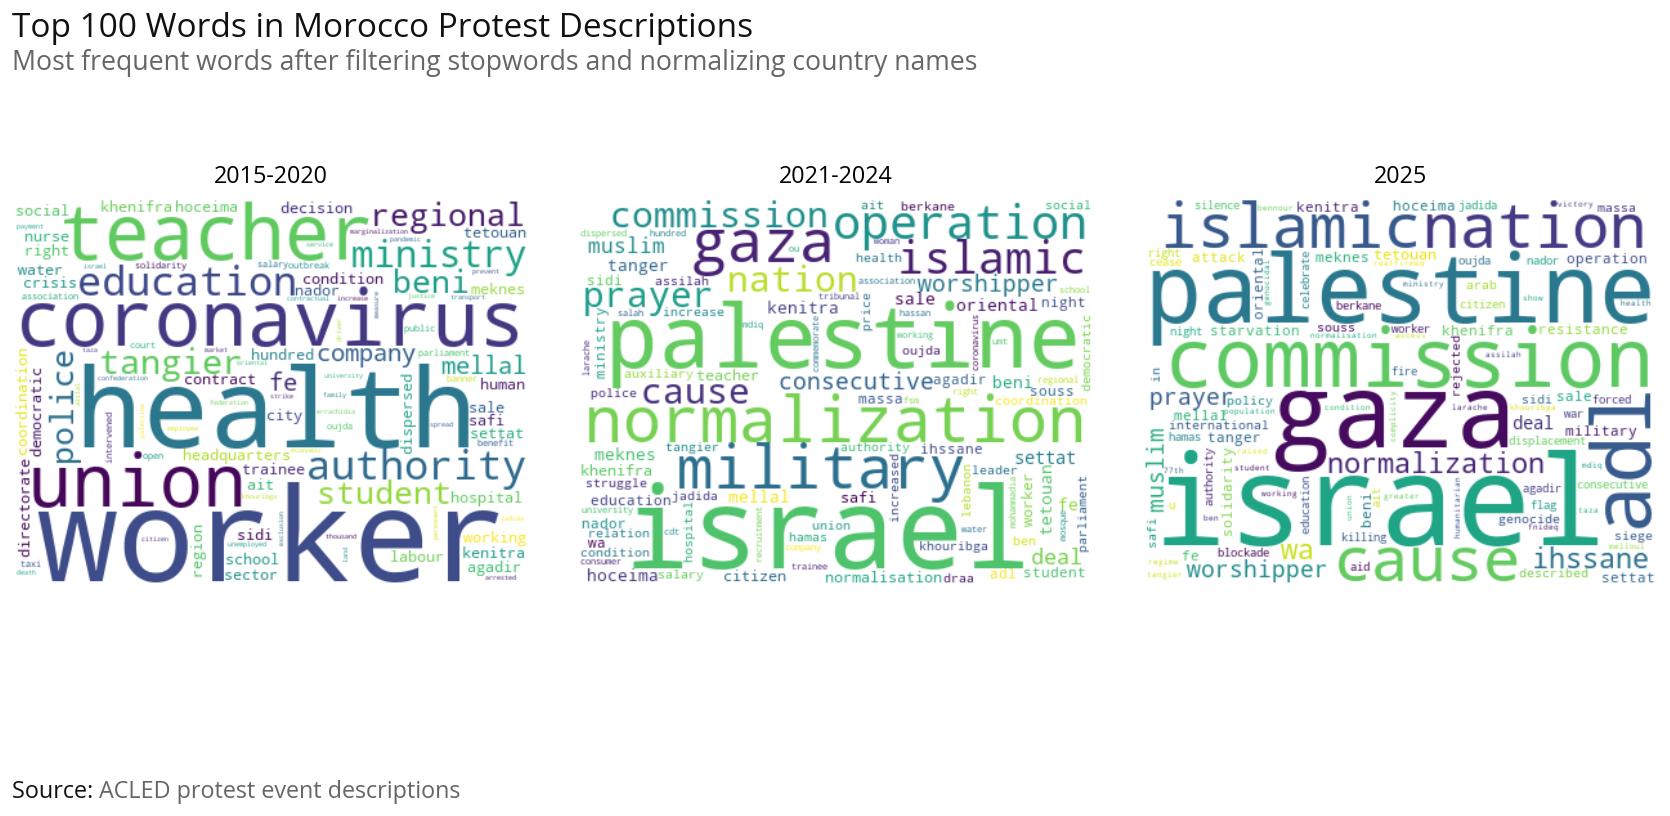

In [88]:
# Create word cloud comparison using the new function
from visuals import *

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

n=100
word_freq_1 = dict(zip(mor_wc_2015_2020['Word'][:n], mor_wc_2015_2020['Count'][:n]))
word_freq_2 = dict(zip(mor_wc_2021_2024['Word'][:n], mor_wc_2021_2024['Count'][:n]))
word_freq_3 = dict(zip(mor_wc_2025['Word'][:n], mor_wc_2025['Count'][:n]))

plot_wordcloud_comparison(
    word_freq_dicts=[word_freq_1, word_freq_2, word_freq_3],
    subplot_titles=['2015-2020', '2021-2024', '2025'],
    main_title=f'Top {n} Words in Morocco Protest Descriptions',
    subtitle='Most frequent words after filtering stopwords and normalizing country names',
    note='ACLED protest event descriptions',
    figsize=(14, 7),
    ncols=3
);

## Protest Topics using TF-IDF

This section uses advanced natural language processing to identify distinct protest topics/themes:

**Method**: TF-IDF (Term Frequency-Inverse Document Frequency) with K-means clustering identifies groups of protest events that share similar language and themes.

**Process**:
1. **Text Preprocessing**: Apply word normalization and custom stopwords to clean the data
2. **TF-IDF Vectorization**: Convert text to numerical features, weighting words by their importance

**Interpretation**: Each topic represents a distinct protest theme (e.g., economic demands, political reform, sectoral grievances). The country distribution shows whether topics are geographically concentrated (country-specific issues) or widespread (regional concerns).

**Time Period Analysis**: We run this analysis separately for 2015-2020, 2021-2024, and 2025 to see how protest themes have evolved over time.

In [92]:
# Extract TF-IDF word frequencies from the topic modeling results
# We need to re-run the topic modeling and capture the TF-IDF vectorizer output

from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

lemmatizer = WordNetLemmatizer()

def get_tfidf_word_frequencies(df, text_column, custom_stopwords, word_normalizations, top_n=100):
    """
    Extract top N words by TF-IDF score from a dataframe.
    
    Returns:
        dict: {word: tfidf_score} for top N words
    """
    # Prepare stopwords
    all_stopwords = set(STOPWORDS).union(set(custom_stopwords))
    all_stopwords_lower = {word.lower() for word in all_stopwords}
    
    def preprocess_text(text):
        """Preprocess text similar to topic modeling pipeline"""
        text = str(text).lower()
        words = re.findall(r'\b\w+\b', text)
        
        # Filter stopwords and non-alphabetic
        filtered = [w for w in words if w not in all_stopwords_lower and w.isalpha() and len(w) > 2]
        
        # Lemmatize
        lemmatized = [lemmatizer.lemmatize(w, pos='n') for w in filtered]
        
        # Apply normalizations
        normalized = [word_normalizations.get(w, w) for w in lemmatized]
        
        return ' '.join(normalized)
    
    # Preprocess all texts
    processed_texts = df[text_column].apply(preprocess_text)
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=top_n * 3,  # Get more features than needed
        min_df=5,  # Ignore terms that appear in fewer than 5 documents
        max_df=0.7  # Ignore terms that appear in more than 70% of documents
    )
    
    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    
    # Get feature names and their average TF-IDF scores
    feature_names = vectorizer.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    
    # Create word-score dictionary
    word_scores = dict(zip(feature_names, mean_tfidf))
    
    # Sort by score and get top N
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return dict(sorted_words)

print("✓ TF-IDF word frequency extraction function created")

✓ TF-IDF word frequency extraction function created


In [93]:
# Extract TF-IDF word frequencies for each time period
print("Extracting TF-IDF word frequencies for 2015-2020...")
tfidf_2015_2020 = get_tfidf_word_frequencies(
    mena_protests_2015_2020.sample(min(100000, len(mena_protests_2015_2020)), random_state=42),
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new'],
    word_normalizations,
    top_n=100
)

print("Extracting TF-IDF word frequencies for 2021-2024...")
tfidf_2021_2024 = get_tfidf_word_frequencies(
    mena_protests_2021_2024.sample(min(100000, len(mena_protests_2021_2024)), random_state=42),
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new'],
    word_normalizations,
    top_n=100
)

print("Extracting TF-IDF word frequencies for 2025...")
tfidf_2025 = get_tfidf_word_frequencies(
    mena_protests_2025,
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new'],
    word_normalizations,
    top_n=100
)

print(f"\n✓ Extracted TF-IDF frequencies:")
print(f"  2015-2020: {len(tfidf_2015_2020)} words")
print(f"  2021-2024: {len(tfidf_2021_2024)} words")
print(f"  2025: {len(tfidf_2025)} words")

Extracting TF-IDF word frequencies for 2015-2020...
Extracting TF-IDF word frequencies for 2021-2024...
Extracting TF-IDF word frequencies for 2021-2024...
Extracting TF-IDF word frequencies for 2025...
Extracting TF-IDF word frequencies for 2025...

✓ Extracted TF-IDF frequencies:
  2015-2020: 100 words
  2021-2024: 100 words
  2025: 100 words

✓ Extracted TF-IDF frequencies:
  2015-2020: 100 words
  2021-2024: 100 words
  2025: 100 words


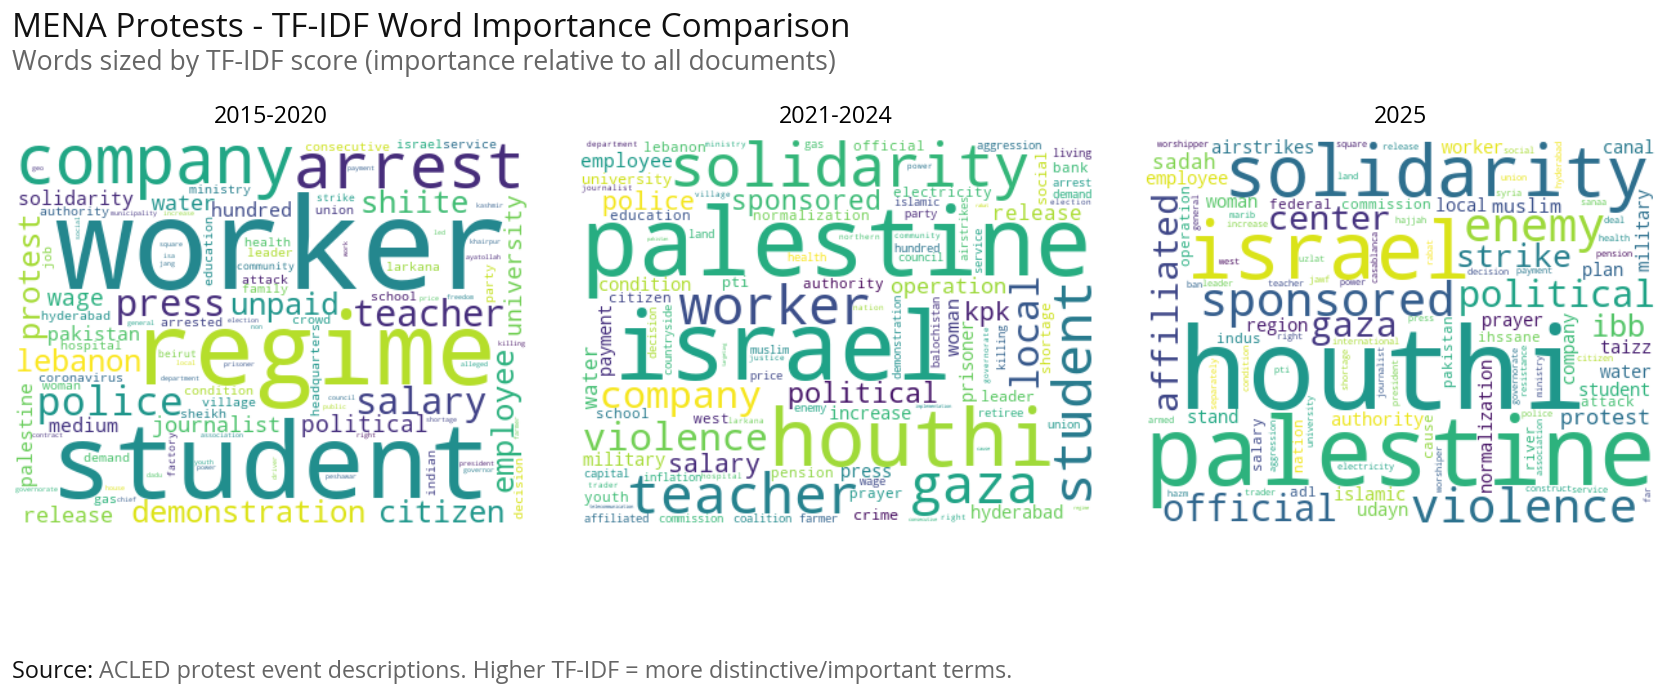

In [94]:
# Create comparative word clouds using TF-IDF scores
from visuals import plot_wordcloud_comparison

plot_wordcloud_comparison(
    word_freq_dicts=[tfidf_2015_2020, tfidf_2021_2024, tfidf_2025],
    subplot_titles=['2015-2020', '2021-2024', '2025'],
    main_title='MENA Protests - TF-IDF Word Importance Comparison',
    subtitle='Words sized by TF-IDF score (importance relative to all documents)',
    note='ACLED protest event descriptions. Higher TF-IDF = more distinctive/important terms.',
    figsize=(14, 6),
    ncols=3,
    max_words=100
)

In [95]:
# Extract TF-IDF word frequencies for each time period
print("Extracting TF-IDF word frequencies for 2015-2020...")
tfidf_2015_2020 = get_tfidf_word_frequencies(
    morocco_2015_2020.sample(min(100000, len(morocco_2015_2020)), random_state=42),
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new']+morocco_custom,
    word_normalizations,
    top_n=100
)

print("Extracting TF-IDF word frequencies for 2021-2024...")
tfidf_2021_2024 = get_tfidf_word_frequencies(
    morocco_2021_2024.sample(min(100000, len(morocco_2021_2024)), random_state=42),
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new']+morocco_custom,
    word_normalizations,
    top_n=100
)

print("Extracting TF-IDF word frequencies for 2025...")
tfidf_2025 = get_tfidf_word_frequencies(
    morocco_2025,
    'notes',
    custom_stopwords + ['yemen', 'six', 'protest', 'new']+morocco_custom,
    word_normalizations,
    top_n=100
)

print(f"\n✓ Extracted TF-IDF frequencies:")
print(f"  2015-2020: {len(tfidf_2015_2020)} words")
print(f"  2021-2024: {len(tfidf_2021_2024)} words")
print(f"  2025: {len(tfidf_2025)} words")

Extracting TF-IDF word frequencies for 2015-2020...
Extracting TF-IDF word frequencies for 2021-2024...
Extracting TF-IDF word frequencies for 2025...

✓ Extracted TF-IDF frequencies:
  2015-2020: 100 words
  2021-2024: 100 words
  2025: 100 words
Extracting TF-IDF word frequencies for 2025...

✓ Extracted TF-IDF frequencies:
  2015-2020: 100 words
  2021-2024: 100 words
  2025: 100 words


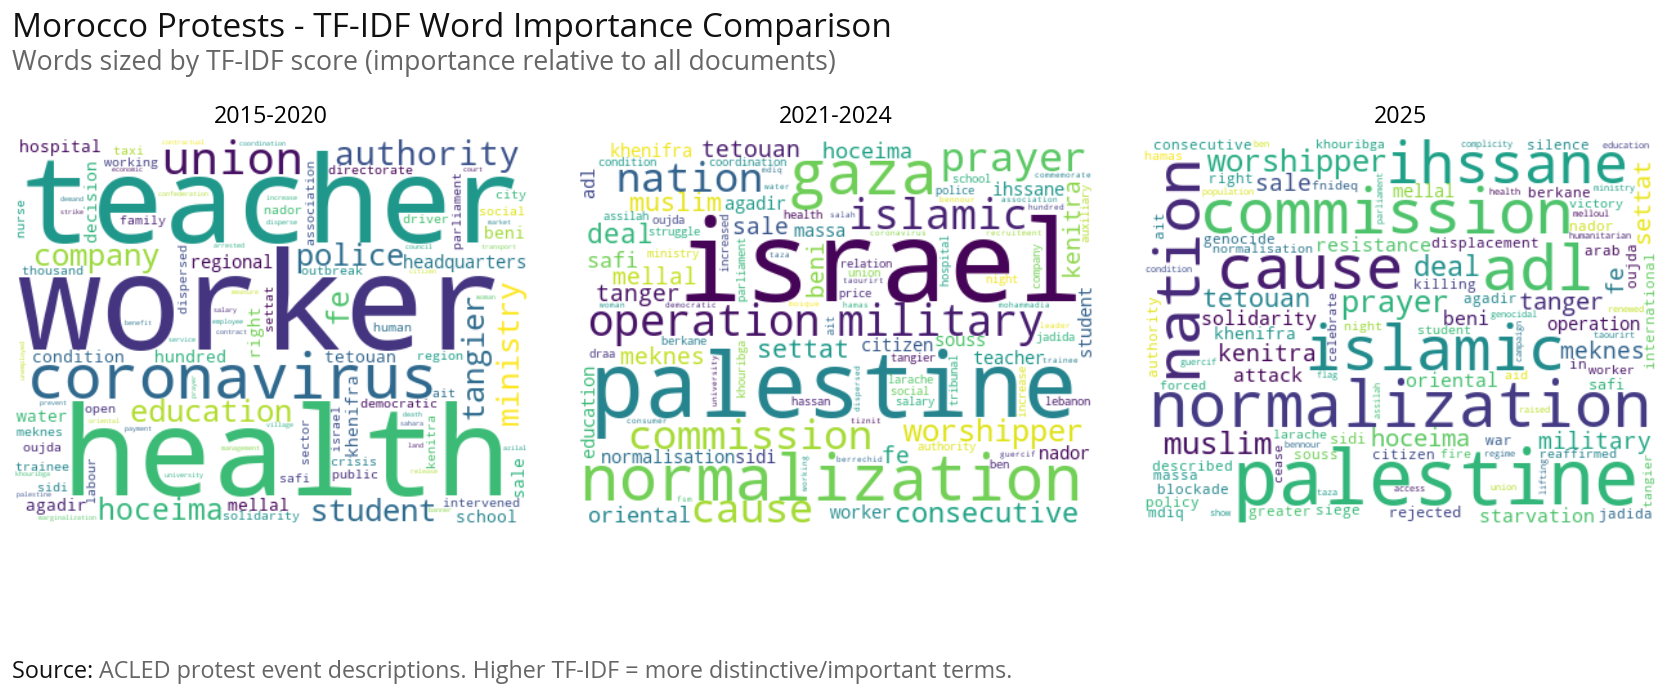

In [96]:
# Create comparative word clouds using TF-IDF scores
from visuals import plot_wordcloud_comparison

plot_wordcloud_comparison(
    word_freq_dicts=[tfidf_2015_2020, tfidf_2021_2024, tfidf_2025],
    subplot_titles=['2015-2020', '2021-2024', '2025'],
    main_title='Morocco Protests - TF-IDF Word Importance Comparison',
    subtitle='Words sized by TF-IDF score (importance relative to all documents)',
    note='ACLED protest event descriptions. Higher TF-IDF = more distinctive/important terms.',
    figsize=(14, 6),
    ncols=3,
    max_words=100
)